In [1]:
import json
import torch
import seaborn
import pylab as mpl
import matplotlib.pyplot as plt
from ec_lstm_p_model import get_ec_batch, EC, ECData
from ec_gen_train import Trainer, name_list

mpl.rcParams['font.sans-serif'] = ['DengXian']  
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
with open('./problem_data_a.json', 'r', encoding='utf8')as fp:
    data = json.load(fp)
with open('glove.6B.50d.txt', 'rb') as f:
    lines = f.readlines()

In [3]:
name_dict = dict()
for i, name in enumerate(name_list):
    name_dict[name] = i

In [4]:
trained_dict = dict()
for i in range(len(lines)):
    line = lines[i].split()
    trained_dict[line[0].decode("utf-8").upper()] = [float(line[j]) for j in range(1, 51)]

In [5]:
alpha = 2e-3
epoch_num = 150
mid_size = 64
batch_size = 16
weight_decay = 4e-5
max_grad_norm = -1

In [6]:
glove = ECData(data=data, name_dict=name_dict, trained_dict=trained_dict, 
                       train_path='./ec_train_data.json', test_path='./ec_test_data.json')
glove.get_words()
glove.get_id()

In [7]:
train_data = get_ec_batch(glove.train_content, glove.train_y, batch_size)
test_data = get_ec_batch(glove.test_content, glove.test_y, batch_size)
print(len(train_data), len(test_data), len(test_data) / (len(test_data) + len(train_data)))

81 12 0.12903225806451613


In [8]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
tra_acc1, tes_acc1 = list(), list()
tra_acc2, tes_acc2 = list(), list()
tra_acc3, tes_acc3 = list(), list()
tra_loss, tes_loss = list(), list()
tra_hit1, tes_hit1 = list(), list()
tra_hit2, tes_hit2 = list(), list()
tra_hit3, tes_hit3 = list(), list()

In [9]:
model = EC(inp_size=50, mid_size=mid_size, num_words=glove.word_num, num_types=len(name_list), num_layers=1,
              weight=torch.tensor(glove.embedding, dtype=torch.float))

d:\pycharmprojects\ecnu-eduktm\venv\lib\site-packages\torch\nn\modules\rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [10]:
trainer = Trainer(model=model, train_data=train_data, epoch_num=epoch_num,
                  batch_size=batch_size, alpha=alpha, weight_decay=weight_decay, max_grad_norm=max_grad_norm)
epoch = 0

In [11]:
for epoch in range(epoch_num):
    loss_tot = torch.Tensor([0]).cuda()
    loss_tot += trainer.train_func()

    train_loss, train_acc1, train_acc2, train_acc3, train_hit1, train_hit2, train_hit3 = trainer.model_eval(train_data)
    test_loss, test_acc1, test_acc2, test_acc3, test_hit1, test_hit2, test_hit3 = trainer.model_eval(test_data)

    tra_loss.append(train_loss / len(train_data) / batch_size)
    tes_loss.append(test_loss / len(test_data) / batch_size)
    tra_acc1.append(train_acc1)
    tes_acc1.append(test_acc1)
    tra_acc2.append(train_acc2)
    tes_acc2.append(test_acc2)
    tra_acc3.append(train_acc3)
    tes_acc3.append(test_acc3)
    tra_hit1.append(train_hit1)
    tes_hit1.append(test_hit1)
    tra_hit2.append(train_hit2)
    tes_hit2.append(test_hit2)
    tra_hit3.append(train_hit3)
    tes_hit3.append(test_hit3)
    print("---------- iteration", epoch + 1, "----------")
    print("total loss:", loss_tot.item())
    print("train loss:", train_loss / len(train_data), ", ", "test loss:", test_loss / len(test_data))
    print("train acc:", train_acc1, ", ", "test acc:", test_acc1)
    print("train hit:", train_hit2, ", ", "test hit:", test_hit2)
    if train_acc1 > 0.50 and test_acc1 > 0.25 and epoch > 30:
        break

D:\PyCharmProjects\ecnu-EduKTM\test12a\ec_gen_train.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  acc = torch.mean((torch.tensor(pred == y, dtype=torch.float)))


---------- iteration 1 ----------
total loss: 531.1211547851562
train loss: 5.141888488957911 ,  test loss: 4.305808266003926
train acc: 0.19907407407407407 ,  test acc: 0.421875
train hit: 0.5268803297737499 ,  test hit: 0.650175596276919
---------- iteration 2 ----------
total loss: 376.7411804199219
train loss: 4.355502060901972 ,  test loss: 3.573099950949351
train acc: 0.2646604938271605 ,  test acc: 0.4322916666666667
train hit: 0.5291308028462492 ,  test hit: 0.6406270861625671
---------- iteration 3 ----------
total loss: 336.75762939453125
train loss: 4.011390727243306 ,  test loss: 3.3956058025360107
train acc: 0.2515432098765432 ,  test acc: 0.3854166666666667
train hit: 0.4706178158521652 ,  test hit: 0.5316869194308916
---------- iteration 4 ----------
total loss: 307.22174072265625
train loss: 3.8757727175583074 ,  test loss: 3.315233131249746
train acc: 0.19753086419753085 ,  test acc: 0.3177083333333333
train hit: 0.3705671195078779 ,  test hit: 0.43316343799233437
----

In [12]:
epoch += 1 

trainer.model_save(epoch, './results/ec_lstm+_model.pth')

In [13]:
trainer.model_valid(glove, './results/ec_lstm+_valid.json')

In [14]:
print('train_acc_every:', tra_acc1[-1], ', train_acc_partof:', tra_acc2[-1], ', train_acc_single:', tra_acc3[-1])
print('test_acc_every:', tes_acc1[-1], ', test_acc_partof:', tes_acc2[-1], ', test_acc_single:', tes_acc3[-1])
print('train_recall:', tra_hit2[-1], ', train_precision:', tra_hit1[-1], ', train_F1:', tra_hit3[-1])
print('test_recall:', tes_hit2[-1], ', test_precision:', tes_hit1[-1], ', test_F1:', tes_hit3[-1])

train_acc_every: 0.7762345679012346 , train_acc_partof: 0.8541666666666666 , train_acc_single: 0.9553433641975309
test_acc_every: 0.3229166666666667 , test_acc_partof: 0.5 , test_acc_single: 0.869140625
train_recall: 0.8533957696255342 , train_precision: 0.998199596081251 , train_F1: 0.9201354986244389
test_recall: 0.5572945897777876 , test_precision: 0.8567717919747034 , test_F1: 0.6753208908763892


In [15]:
print('train_acc_every_max:', max(tra_acc1), ', train_acc_partof_max:', max(tra_acc2), ', train_acc_single_max:', max(tra_acc3))
print('test_acc_every_max:', max(tes_acc1), ', test_acc_partof_max:', max(tes_acc2), ', test_acc_single_max:', max(tes_acc3))
print('train_recall_max:', max(tra_hit2), ', train_precision_max:', max(tra_hit1), ', train_F1_max:', max(tra_hit3))
print('test_recall_max:', max(tes_hit2), ', test_precision_max:', max(tes_hit1), ', test_F1_max:', max(tes_hit3))

train_acc_every_max: 0.7916666666666666 , train_acc_partof_max: 0.8734567901234568 , train_acc_single_max: 0.9593942901234568
test_acc_every_max: 0.4322916666666667 , test_acc_partof_max: 0.609375 , test_acc_single_max: 0.8984375
train_recall_max: 0.867091695467631 , train_precision_max: 0.9992283980051676 , train_F1_max: 0.9275374595841896
test_recall_max: 0.650175596276919 , test_precision_max: 1.0 , test_F1_max: 0.7602805556938267


In [16]:
file = open("./results/ec_lstm+_desc.txt",'w') 
print('train_acc_every:', tra_acc1[-1], ', train_acc_partof:', tra_acc2[-1], ', train_acc_single:', tra_acc3[-1], file=file)
print('test_acc_every:', tes_acc1[-1], ', test_acc_partof:', tes_acc2[-1], ', test_acc_single:', tes_acc3[-1], file=file)
print('train_recall:', tra_hit2[-1], ', train_precision:', tra_hit1[-1], ', train_F1:', tra_hit3[-1], file=file)
print('test_recall:', tes_hit2[-1], ', test_precision:', tes_hit1[-1], ', test_F1:', tes_hit3[-1], file=file)
print('', file=file)
print('train_acc_every_max:', max(tra_acc1), ', train_acc_partof_max:', max(tra_acc2), ', train_acc_single_max:', max(tra_acc3), file=file)
print('test_acc_every_max:', max(tes_acc1), ', test_acc_partof_max:', max(tes_acc2), ', test_acc_single_max:', max(tes_acc3), file=file)
print('train_recall_max:', max(tra_hit2), ', train_precision_max:', max(tra_hit1), ', train_F1_max:', max(tra_hit3), file=file)
print('test_recall_max:', max(tes_hit2), ', test_precision_max:', max(tes_hit1), ', test_F1_max:', max(tes_hit3), file=file)
print('', file=file)
print('train_acc_every:', tra_acc1, file=file)
print('train_acc_partof:', tra_acc2, file=file)
print('train_acc_every:', tra_acc3, file=file)
print('test_acc_every:', tes_acc1, file=file)
print('test_acc_partof:', tes_acc2, file=file)
print('test_acc_single:', tes_acc3, file=file)
print('train_recall:', tra_hit2, file=file)
print('train_precision:', tra_hit1, file=file)
print('train_F1:', tra_hit3, file=file)
print('test_recall:', tes_hit2, file=file)
print('test_precision:', tes_hit1, file=file)
print('test_F1:', tes_hit3, file=file)
file.close()

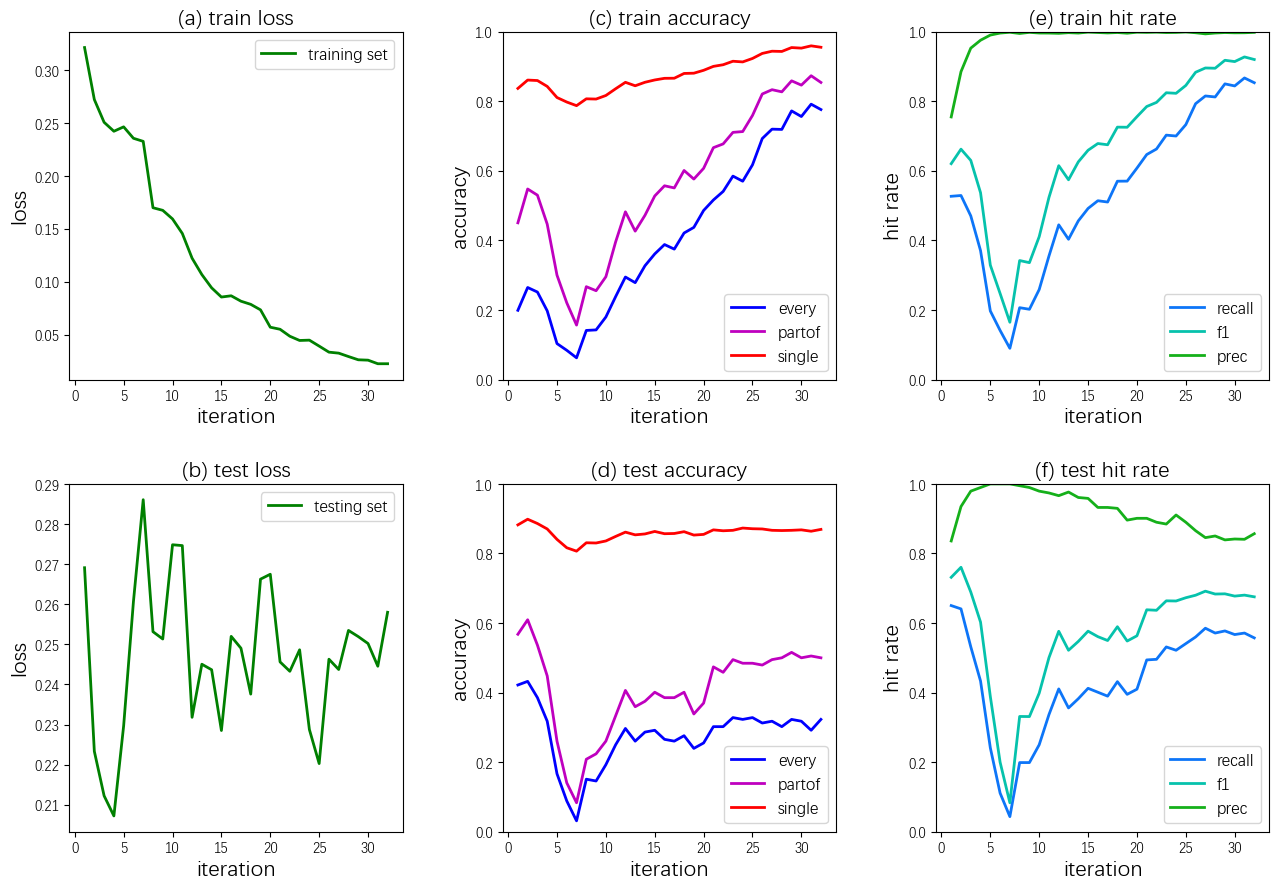

In [17]:
x_range = list(range(1, epoch+1))
fig = plt.figure(num=1, figsize=(15, 10), dpi=100, clear=True)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.3, wspace=0.3)
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2)
ax3 = fig.add_subplot(2, 3, 3)
ax4 = fig.add_subplot(2, 3, 4)
ax5 = fig.add_subplot(2, 3, 5)
ax6 = fig.add_subplot(2, 3, 6)

l1, = ax1.plot(x_range, tra_loss, c='g', lw='2')
ax1.set_title('(a) train loss', fontsize=16)
ax1.set_xlabel('iteration', fontsize=16)
ax1.set_ylabel('loss', fontsize=16)
ax1.legend([l1], ['training set'], fontsize=12)  

l1,  = ax4.plot(x_range, tes_loss, c='g', lw='2')
ax4.set_title('(b) test loss', fontsize=16)
ax4.set_xlabel('iteration', fontsize=16)
ax4.set_ylabel('loss', fontsize=16)
ax4.legend([l1], ['testing set'], fontsize=12)  

l1,  = ax2.plot(x_range, tra_acc1, c='b', lw='2')
l2,  = ax2.plot(x_range, tra_acc2, c='m', lw='2')
l3,  = ax2.plot(x_range, tra_acc3, c='r', lw='2')
ax2.set_title('(c) train accuracy', fontsize=16)
ax2.set_xlabel('iteration', fontsize=16)
ax2.set_ylabel('accuracy', fontsize=16)
ax2.set_ylim((0, 1))
ax2.legend([l1, l2, l3], ['every', 'partof', 'single'], fontsize=12)  

l1,  = ax5.plot(x_range, tes_acc1, c='b', lw='2')
l2,  = ax5.plot(x_range, tes_acc2, c='m', lw='2')
l3,  = ax5.plot(x_range, tes_acc3, c='r', lw='2')
ax5.set_title('(d) test accuracy', fontsize=16)
ax5.set_xlabel('iteration', fontsize=16)
ax5.set_ylabel('accuracy', fontsize=16)
ax5.set_ylim((0, 1))
ax5.legend([l1, l2, l3], ['every', 'partof', 'single'], fontsize=12)  

l1,  = ax3.plot(x_range, tra_hit1, c=seaborn.xkcd_rgb['green'], lw='2')
l2,  = ax3.plot(x_range, tra_hit2, c=seaborn.xkcd_rgb['deep sky blue'], lw='2')
l3,  = ax3.plot(x_range, tra_hit3, c=seaborn.xkcd_rgb['turquoise'], lw='2')
ax3.set_title('(e) train hit rate', fontsize=16)
ax3.set_xlabel('iteration', fontsize=16)
ax3.set_ylabel('hit rate', fontsize=16)
ax3.set_ylim((0, 1))
ax3.legend([l2, l3, l1], ['recall', 'f1', 'prec'], fontsize=12)  

l1,  = ax6.plot(x_range, tes_hit1, c=seaborn.xkcd_rgb['green'], lw='2')
l2,  = ax6.plot(x_range, tes_hit2, c=seaborn.xkcd_rgb['deep sky blue'], lw='2')
l3,  = ax6.plot(x_range, tes_hit3, c=seaborn.xkcd_rgb['turquoise'], lw='2')
ax6.set_title('(f) test hit rate', fontsize=16)
ax6.set_xlabel('iteration', fontsize=16)
ax6.set_ylabel('hit rate', fontsize=16)
ax6.set_ylim((0, 1))
ax6.legend([l2, l3, l1], ['recall', 'f1', 'prec'], fontsize=12)  

plt.savefig('./results/ec_lstm+_total.jpg')